# <font color='red'> Risk analysis by clustering and pipelines

1. Problem defining
2. EDA
3. Features
4. Data Preprocessing
5. Clustering
6. Modeling

# 1. Problem defining

 ##  <font color='blue'> - Evaluating the risk involved with a loan.
 ## <font color='blue'>  - Customer segmentation based on risks and other factors.
 ## <font color='blue'>  - Metrics and methods towards accurate customer loan risk management

In [69]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt#plt.style.use('fivethirtyeight')#sns.set_style('whitegrid')
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from scipy.stats import uniform
from scipy import interp
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.metrics import silhouette_samples, silhouette_score
from bayes_opt import BayesianOptimization
df = pd.read_csv('../input/german-credit-data-with-risk/german_credit_data.csv')

In [70]:
#show data frame
df.info()
df.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        1000 non-null   int64 
 1   Age               1000 non-null   int64 
 2   Sex               1000 non-null   object
 3   Job               1000 non-null   int64 
 4   Housing           1000 non-null   object
 5   Saving accounts   817 non-null    object
 6   Checking account  606 non-null    object
 7   Credit amount     1000 non-null   int64 
 8   Duration          1000 non-null   int64 
 9   Purpose           1000 non-null   object
 10  Risk              1000 non-null   object
dtypes: int64(5), object(6)
memory usage: 86.1+ KB


Index(['Unnamed: 0', 'Age', 'Sex', 'Job', 'Housing', 'Saving accounts',
       'Checking account', 'Credit amount', 'Duration', 'Purpose', 'Risk'],
      dtype='object')

# 2. EDA
---

### Distributions

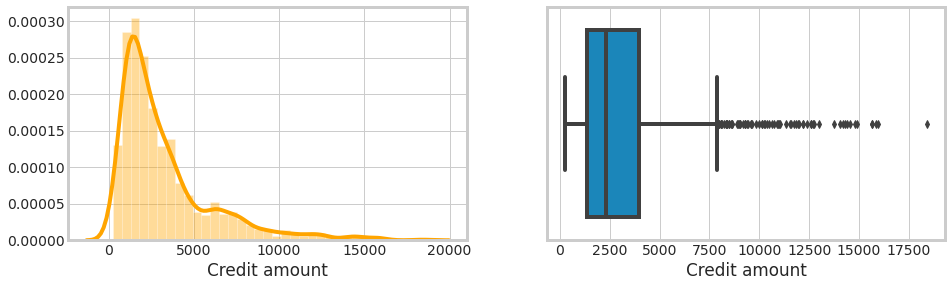

In [89]:
fig,ax=plt.subplots(1,2,figsize=(14,4))
sns.distplot(df['Credit amount'], color='orange',ax=ax[0]);
sns.boxplot(df['Credit amount'],ax=ax[1]);

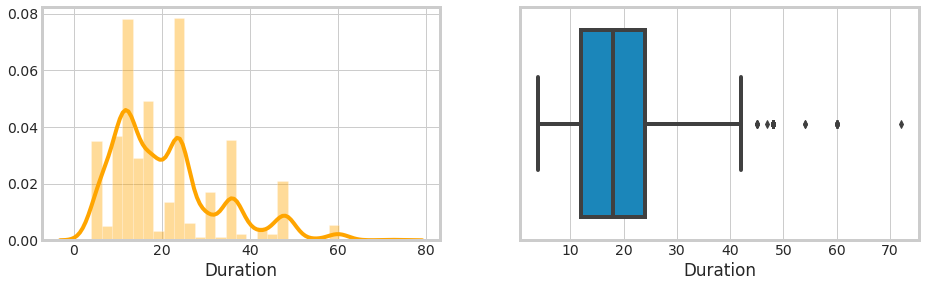

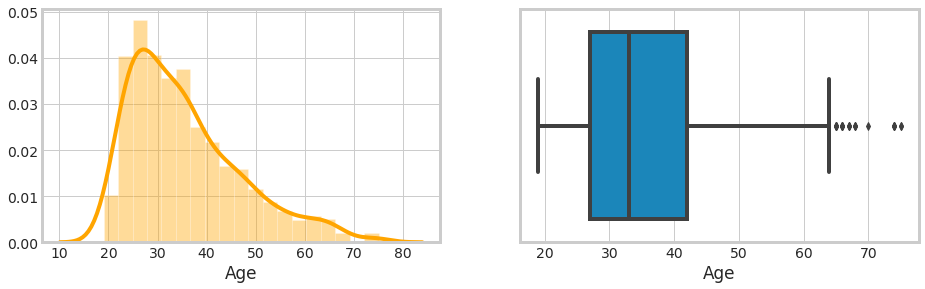

In [90]:
fig,ax=plt.subplots(1,2,figsize=(14,4))
sns.distplot(df['Duration'],  color='orange',ax=ax[0]);
sns.boxplot(df['Duration'],ax=ax[1]);

fig,ax=plt.subplots(1,2,figsize=(14,4))
sns.distplot(df['Age'],  color='orange',ax=ax[0]);
sns.boxplot(df['Age'],ax=ax[1]);

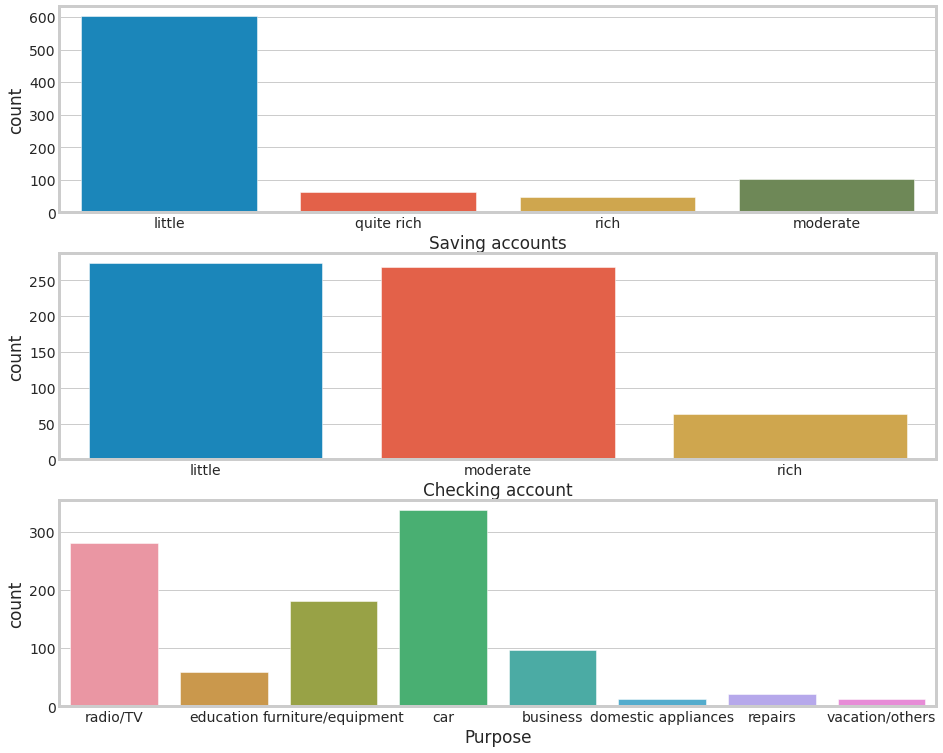

In [93]:
fig, ax = plt.subplots(3,1,figsize=(14,12))
sns.countplot(df['Saving accounts'], ax=ax[0]);
sns.countplot(df['Checking account'], ax=ax[1]);
sns.countplot(df.Purpose, ax=ax[2]);

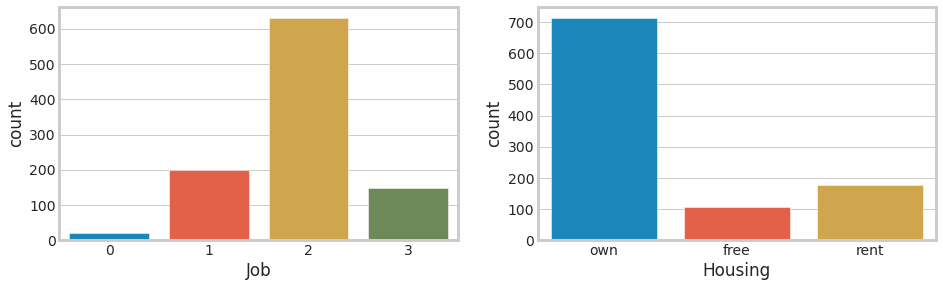

In [94]:
fig, ax = plt.subplots(1,2,figsize=(14,4))
sns.countplot(df['Job'], ax=ax[0]);
sns.countplot(df.Housing, ax=ax[1]);

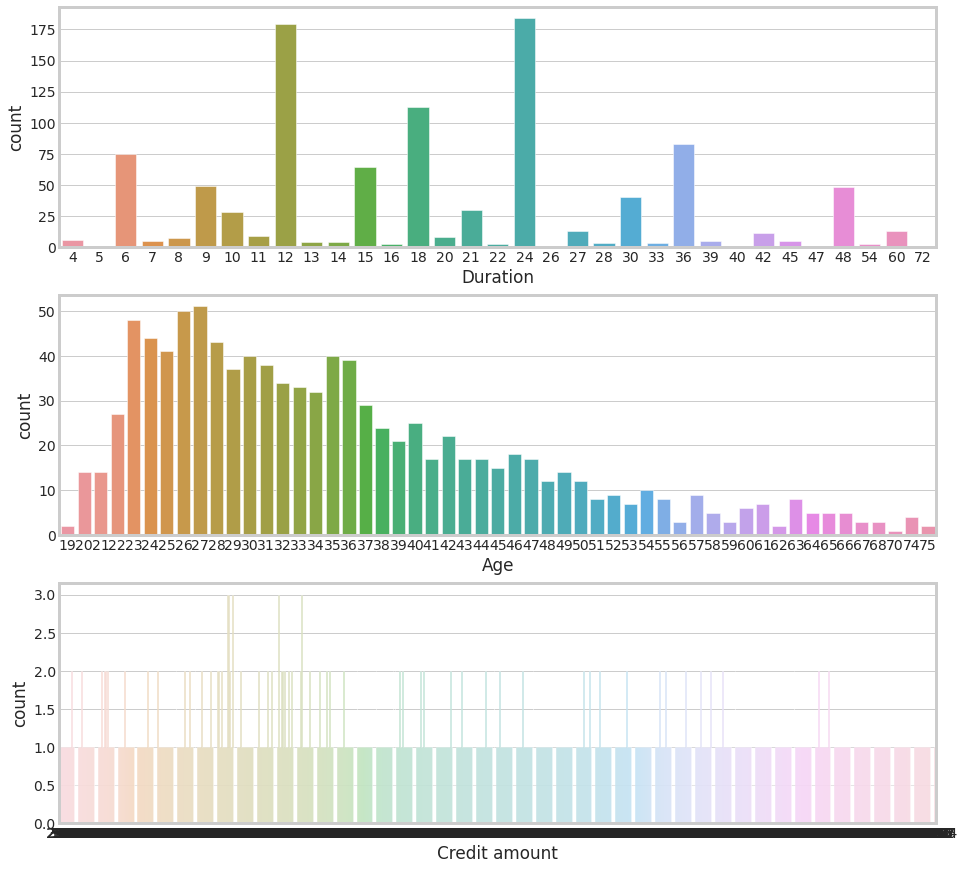

In [99]:
fig, ax = plt.subplots(3,1,figsize=(14,14))
sns.countplot(df.Duration, ax=ax[0]);
sns.countplot(df.Age, ax=ax[1]);
sns.countplot(df['Credit amount'], ax=ax[2]);

### Correlations

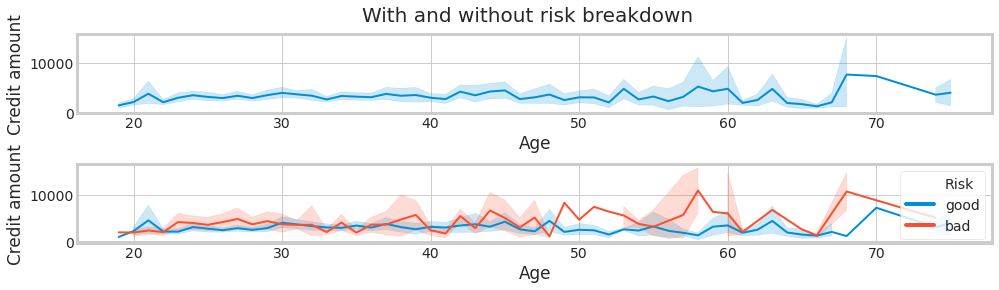

In [109]:
fig, ax = plt.subplots(2,1,figsize=(14,4))
plt.suptitle('With and without risk breakdown', fontsize=20)
plt.tight_layout(2)

sns.lineplot(data=df, x='Age', y='Credit amount',  lw=2, ax=ax[0]);
sns.lineplot(data=df, x='Age', y='Credit amount', hue='Risk', lw=2, ax=ax[1]);



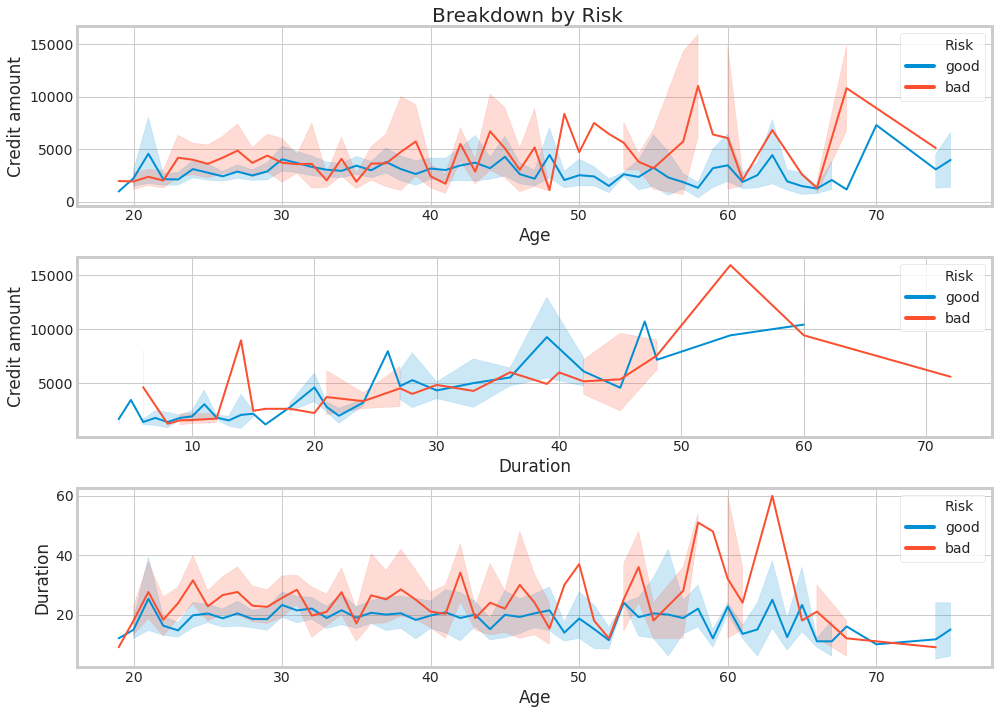

In [110]:
fig, ax = plt.subplots(3,1,figsize=(14,10))
plt.suptitle('Breakdown by Risk', fontsize=20)
plt.tight_layout(2)

sns.lineplot(data=df, x='Age', y='Credit amount', hue='Risk', lw=2, ax=ax[0]);
sns.lineplot(data=df, x='Duration', y='Credit amount', hue='Risk', lw=2, ax=ax[1]);
sns.lineplot(data=df, x='Age', y='Duration', hue='Risk', lw=2, ax=ax[2]);


fig, ax = plt.subplots(3,1,figsize=(14,10))
plt.suptitle('Breakdown by Housing Type', fontsize=20)
plt.tight_layout(2)

sns.lineplot(data=df, x='Age', y='Credit amount', hue='Housing', lw=2, ax=ax[0]);
sns.lineplot(data=df, x='Duration', y='Credit amount', hue='Housing', lw=2, ax=ax[1]);
sns.lineplot(data=df, x='Age', y='Duration', hue='Housing', lw=2, ax=ax[2]);

seaborn plot types:
https://www.mth548.org/Tools/Seaborn/seaborn_plot_types.html#:~:text=Some%20types%20of%20plots%20%28e.g.%20the%20scatter%20plot,subplots%2C%20one%20subplot%20for%20each%20pair%20of%20variables.

# Stripplots of  Risk, Job, and Housing Breakdown

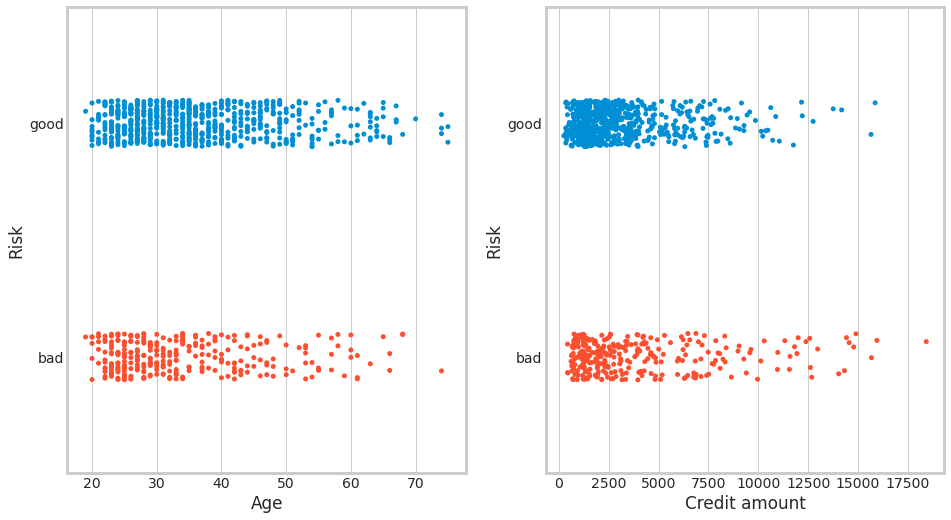

In [146]:
fig, ax = plt.subplots(1,2,figsize=(14,8))
sns.stripplot(data=df, x='Age', y='Risk',   ax=ax[0]);
sns.stripplot(data=df, x='Credit amount', y='Risk',  ax=ax[1]);

fig, ax = plt.subplots(2,1,figsize=(14,8))
sns.stripplot(data=df, x='Age', y='Job',   ax=ax[0]);
sns.stripplot(data=df, x='Credit amount', y='Job',  ax=ax[1]);

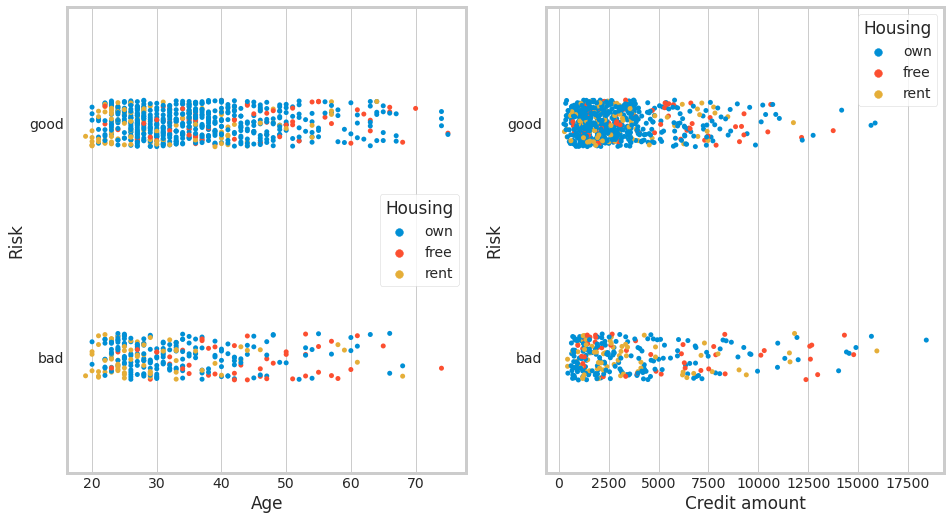

In [147]:
fig, ax = plt.subplots(1,2,figsize=(14,8))
sns.stripplot(data=df, x='Age', y='Risk', hue='Housing',  ax=ax[0]);
sns.stripplot(data=df, x='Credit amount', y='Risk', hue='Housing', ax=ax[1]);

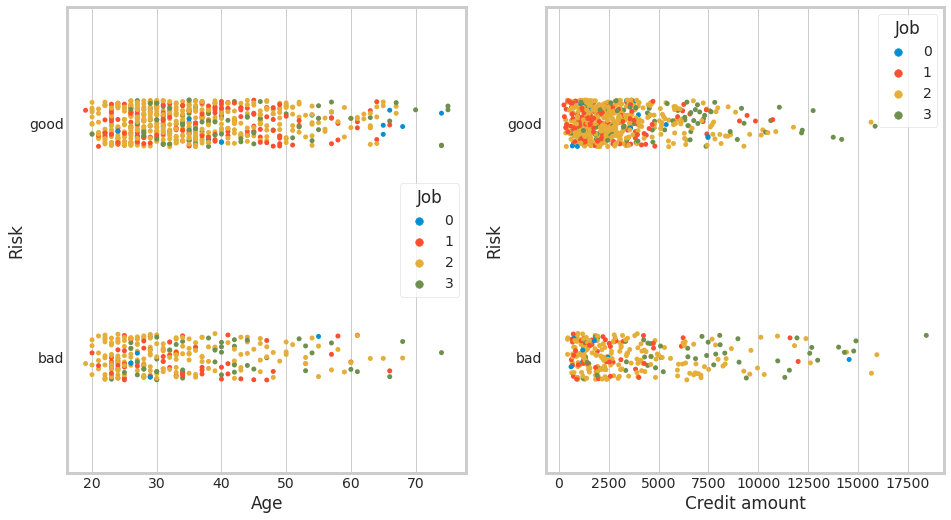

In [148]:
fig, ax = plt.subplots(1,2,figsize=(14,8))
sns.stripplot(data=df, x='Age', y='Risk', hue='Job',  ax=ax[0]);
sns.stripplot(data=df, x='Credit amount', y='Risk', hue='Job', ax=ax[1]);

# 3. Features

In [157]:
df1=df[['Age', 'Sex', 'Job', 'Housing', 'Saving accounts',
       'Checking account', 'Credit amount', 'Duration', 'Purpose', 'Risk']]

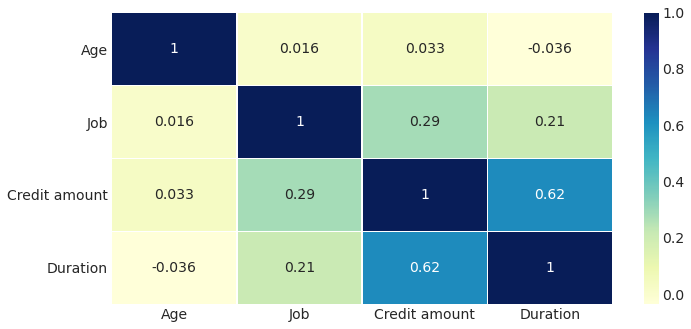

In [163]:

fig, ax = plt.subplots(figsize=(10,5))  
sns.heatmap(df1.corr(), cmap="YlGnBu", annot=True, linewidths=.5, ax=ax)

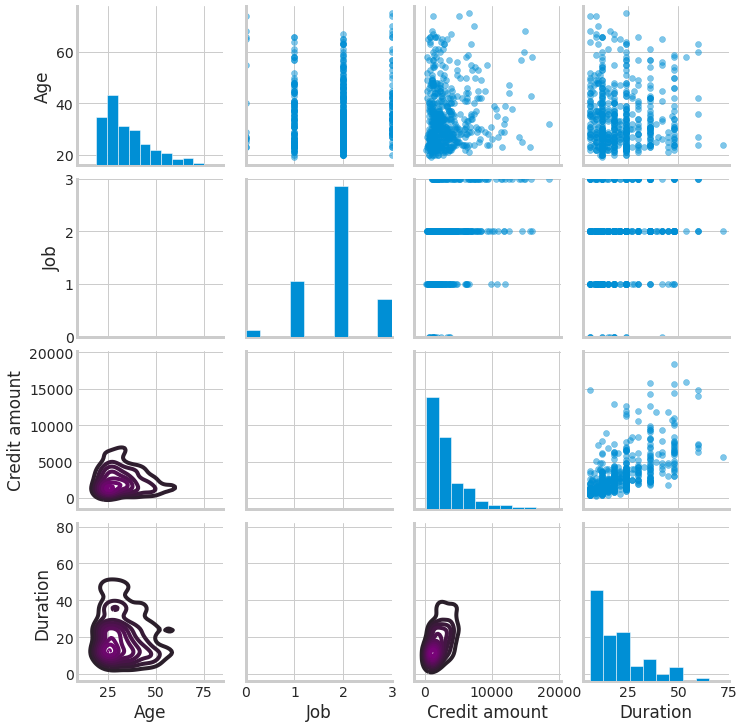

In [164]:
return_fig = sns.PairGrid(df1.dropna())
return_fig.map_upper(plt.scatter,alpha=0.5)
return_fig.map_lower(sns.kdeplot,color='purple')
return_fig.map_diag(plt.hist)

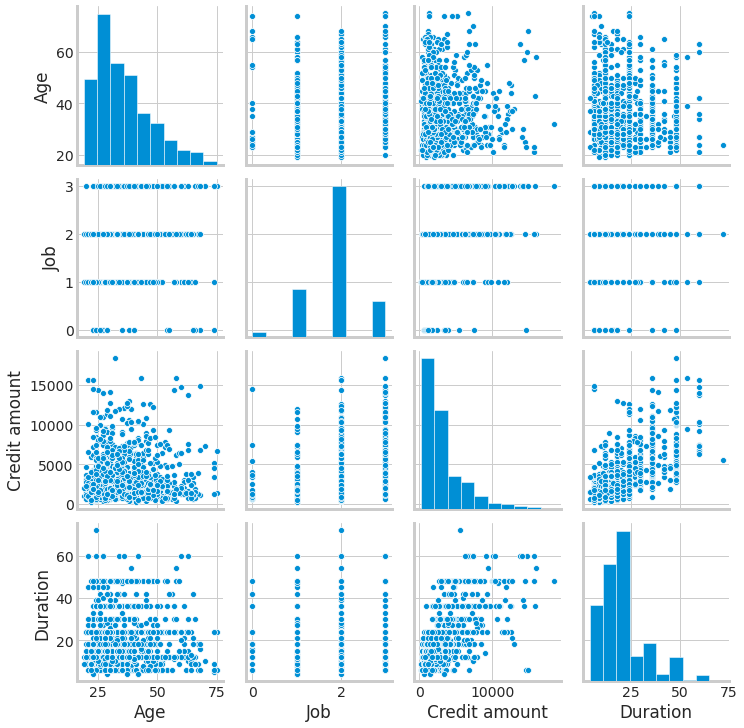

In [165]:

import matplotlib.pyplot as mp
import seaborn as sns
sns.pairplot(df1)

# 4. Data preprocessing: fillna, label encode, log transform, and scale
---

In [174]:
df1= df1.fillna('unknown')
df1.isnull().sum()

Age                 0
Sex                 0
Job                 0
Housing             0
Saving accounts     0
Checking account    0
Credit amount       0
Duration            0
Purpose             0
Risk                0
dtype: int64

In [181]:
categorical_features = ['Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Purpose', 'Risk']
for i, cat in enumerate(categorical_features):
    df1[cat] = LabelEncoder().fit_transform(df1[cat])
df1.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,1,2,1,4,0,1169,6,5,1
1,22,0,2,1,0,1,5951,48,5,0
2,49,1,1,1,0,3,2096,12,3,1
3,45,1,2,0,0,0,7882,42,4,1
4,53,1,2,0,0,0,4870,24,1,0


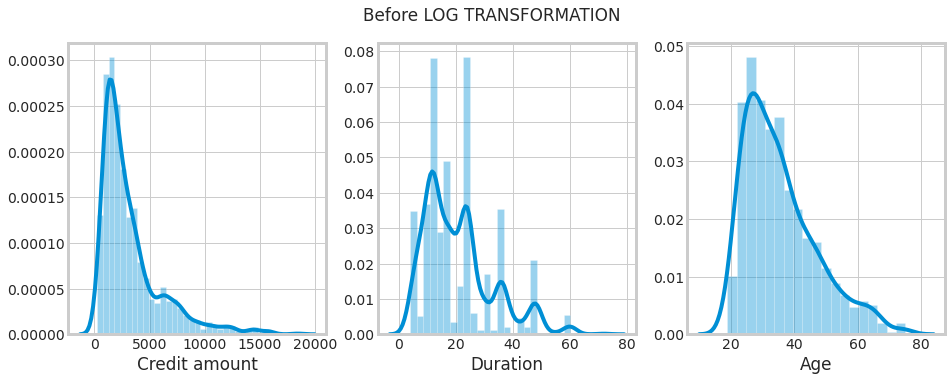

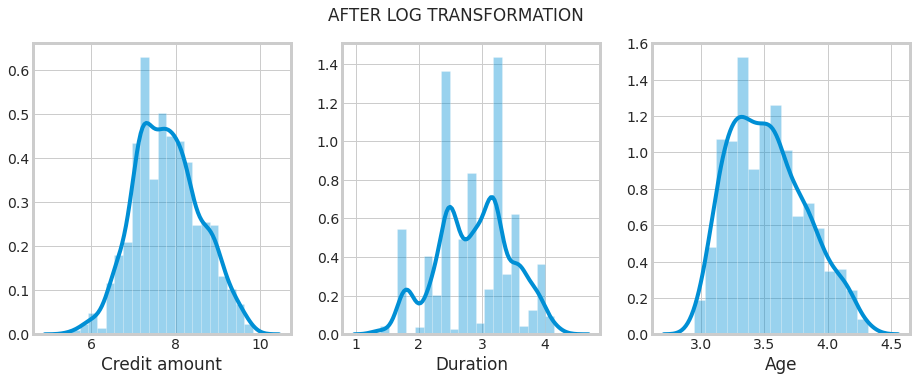

In [186]:
fig, ax = plt.subplots(1,3,figsize=(14,5))
plt.suptitle('Before LOG TRANSFORMATION')
sns.distplot(df1['Credit amount'],  ax=ax[0]);
sns.distplot(df1['Duration'],ax=ax[1]);
sns.distplot(df1['Age'], ax=ax[2]);

num_df = df1[['Age', 'Duration', 'Credit amount']]
num_df = np.log(num_df)

fig, ax = plt.subplots(1,3,figsize=(14,5))
plt.suptitle('AFTER LOG TRANSFORMATION')
sns.distplot(num_df['Credit amount'],  ax=ax[0]);
sns.distplot(num_df['Duration'],ax=ax[1]);
sns.distplot(num_df['Age'], ax=ax[2]);

In [187]:
scaler = StandardScaler()
num_df_scaled = scaler.fit_transform(num_df)
print(num_df_scaled.shape)

(1000, 3)


# 5. CLUSTERING
---

### K-MEANS

#### APPLYING ELBOW METHOD TO FIND THE BEST NUMBER OF CLUSTERS

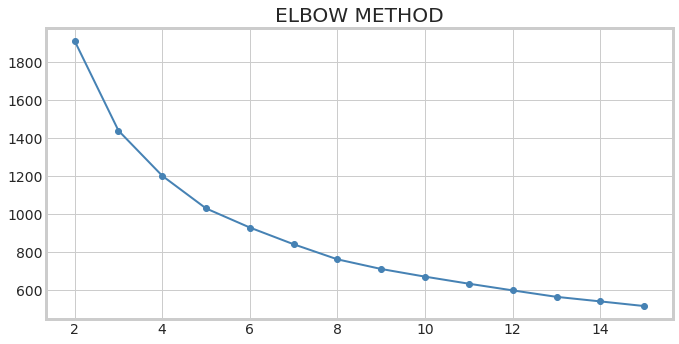

In [25]:
inertias = []

for i in range(2,16):
    kmeans = KMeans(n_clusters=i, random_state=0).fit(num_df_scaled)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(10,5))
plt.title('ELBOW METHOD')
plt.plot(np.arange(2,16),inertias, marker='o', lw=2, color='steelblue');

#### ALTERNATIVE METHOD: SILHOUTE SCORE WITH RANDOM SAMPLING

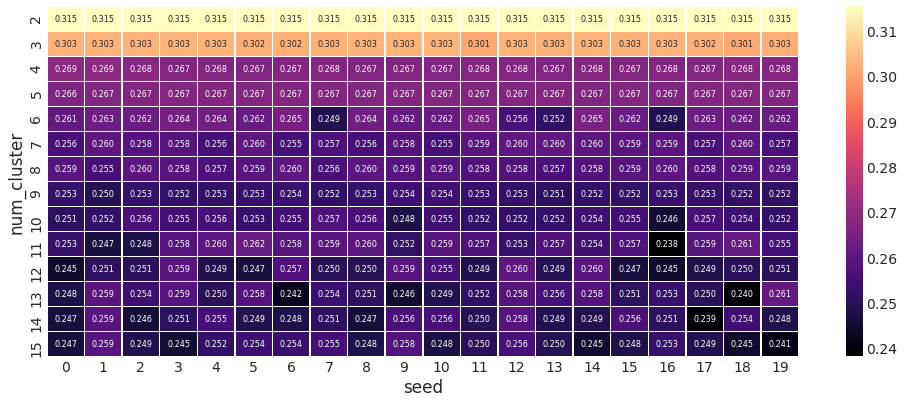

In [26]:
results = []

for i in range(2,16):
    for r in range(20):
        kmeans = KMeans(n_clusters=i, random_state=r)
        c_labels = kmeans.fit_predict(num_df_scaled)
        sil_ave = silhouette_score(num_df_scaled, c_labels)
        results.append([i, r, sil_ave])
        
res_df = pd.DataFrame(results, columns=['num_cluster', 'seed', 'sil_score'])
pivot_kmeans = pd.pivot_table(res_df, index='num_cluster', columns='seed', values='sil_score')

plt.figure(figsize=(15,6))
plt.tight_layout
sns.heatmap(pivot_kmeans, annot=True, linewidths=0.5, fmt='.3f', cmap='magma', annot_kws={"size":8});

* The scores of 2,3,4 and 5 are pretty stable, Let's pick a number of cluster from that range.

#### AT 3 NUMBER OF CLUSTERS

In [27]:
km = KMeans(n_clusters=3, random_state=0)
clusters = km.fit_predict(num_df_scaled)

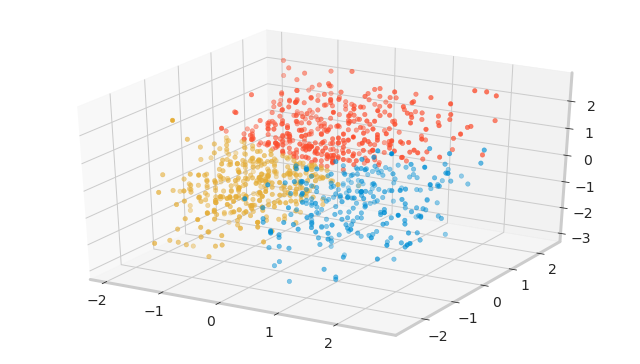

In [28]:
#show a 3D plot of clusters
from mpl_toolkits.mplot3d import Axes3D 
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')

for i in range(3):
    ax.scatter(num_df_scaled[clusters ==i,0], num_df_scaled[clusters ==i,1], num_df_scaled[clusters ==i,2])
    


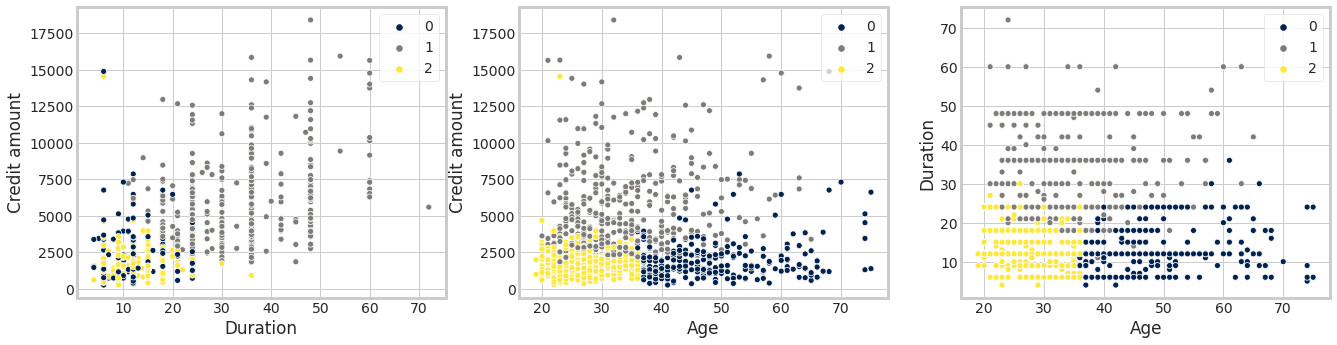

In [29]:
fig, ax  = plt.subplots(1,3,figsize=(20,5))
sns.scatterplot(df['Duration'], df['Credit amount'], hue=clusters, ax=ax[0], palette='cividis');
sns.scatterplot(df['Age'], df['Credit amount'], hue=clusters, ax=ax[1], palette='cividis');
sns.scatterplot(df['Age'], df['Duration'], hue=clusters, ax=ax[2], palette='cividis');

#### LET'S CREATE A DATAFRAME TO SUMMARIZE THE RESULT

In [30]:
df_clustered = df[['Age', 'Duration', 'Credit amount']]
df_clustered['cluster'] = clusters

In [31]:
df_clustered.groupby('cluster').mean()

,Age,Duration,Credit amount
cluster,,,
0,48.691120,13.918919,1979.745174
1,34.042667,32.224000,5665.384000
2,27.784153,14.245902,1732.199454


* Cluster 0 are the older customers.
* Cluster 1 are the middle-Aged customers.
* Cluster 2 are the younger customers.

# 6. MODELLING
---

In [32]:
num_df_scaled = pd.DataFrame(num_df_scaled, columns=['Age', 'Duration', 'Credit Amount'])
cat_df = df[categorical_features]

data = pd.concat([cat_df, num_df_scaled], axis=1)

In [33]:
#show new dataframe
data.head()

,Sex,Job,Housing,Saving accounts,Checking account,Purpose,Risk,Age,Duration,Credit Amount
0,1,2,1,4,0,5,1,2.271006,-1.864869,-0.933901
1,0,2,1,0,1,5,0,-1.446152,1.708369,1.163046
2,1,1,1,0,3,3,1,1.226696,-0.673790,-0.181559
3,1,2,0,0,0,4,1,0.942455,1.478913,1.525148
4,1,2,0,0,0,1,0,1.488620,0.517289,0.904743


### XGBOOST MODEL

#### SPLIT THE DATA

In [34]:
x = data.drop('Risk', axis=1)
y = data['Risk']

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=101)

print('xtrain shape: ', x_train.shape)
print('xtest shape: ', x_test.shape)
print('ytrain shape: ', y_train.shape)
print('ytest shape: ', y_test.shape)


xtrain shape:  (800, 9)
xtest shape:  (200, 9)
ytrain shape:  (800,)
ytest shape:  (200,)


#### HYPERPARAMETER TUNING

In [35]:
#RandomSearchCV
# define the parameters to tune
param_dist = {"learning_rate": uniform(0, 2),
              "gamma": uniform(1, 0.000001),
              "max_depth": range(1,50),
              "n_estimators": range(1,300),
              "min_child_weight": range(1,10),
              'n_jobs': range(1,5)}
#instance of RandomSearchCV
rs = RandomizedSearchCV(XGBClassifier(), param_distributions=param_dist, n_iter=25) #25 iterations

In [36]:
rs.fit(x_train, y_train)

RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_job...
                                           subsample=None, tree_method=None,
                                           validate_parameters=None,
                                           verbosity=N

#### PREDICT THE TEST DATA

In [37]:
predictions = rs.predict(x_test)

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.71      0.43      0.54        69
           1       0.75      0.91      0.82       131

    accuracy                           0.74       200
   macro avg       0.73      0.67      0.68       200
weighted avg       0.74      0.74      0.73       200



#7. Evaluation

In [38]:
def plot_roc(X, y, estemator,n_splits, lns = 100):
    #creating an instance of KFold
    kfold = StratifiedKFold(n_splits=n_splits,shuffle=False)
    #define estemator
    rf = estemator
    #deifne figuresize
    plt.rcParams['figure.figsize'] = (10,5)
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0,1,lns)
    i = 1

    for train,test in kfold.split(X,y):
        #get prediction
        prediction = rf.fit(X.iloc[train],y.iloc[train]).predict_proba(X.iloc[test])
        #get the true pos. rate, false positive rate and thresh 
        fpr, tpr, t = roc_curve(y[test], prediction[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        #get the area under the curve
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        #plot the tpr and fpr
        plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        i= i+1

    #plot the mean ROC
    plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
    mean_tpr = np.mean(tprs, axis=0)
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, color='gold',
    label=r'Mean ROC (AUC = %0.2f )' % (mean_auc),lw=2, alpha=1)

    #setup the labels
    plt.legend(bbox_to_anchor=(1, 1))
    plt.title('ROC PLOT', fontsize=16)
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)

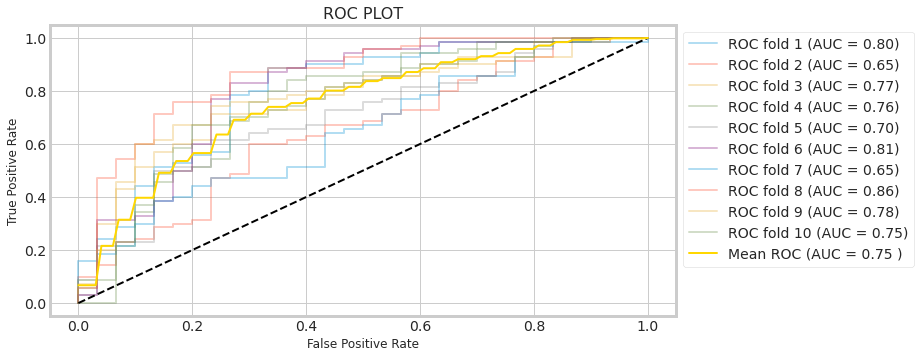

In [39]:
xgb_model = XGBClassifier()
xgb_model.set_params(**rs.best_params_)

plot_roc(x,y, xgb_model, n_splits=10)

# References:

https://www.kaggle.com/code/delllectron/bank-credit-data-clustering-modelling

segmentation:
https://www.kaggle.com/code/paulinan/bank-customer-segmentation

models: 
https://www.kaggle.com/code/hendraherviawan/predicting-german-credit-default#5.-Others

https://www.kaggle.com/code/mathchi/credit-risk-evaluation#3.-Data-Prepcoressing-&-Feature-Engineering

pipeline: 
https://www.kaggle.com/code/kabure/predicting-credit-risk-model-pipeline

other data:
https://www.kaggle.com/datasets/ranadeep/credit-risk-dataset

https://www.kaggle.com/code/janiobachmann/german-credit-analysis-a-risk-perspective/data

https://www.kaggle.com/code/manikhindwan/credit-risk-management-modelling-expected-loss/notebook

https://www.kaggle.com/code/janiobachmann/lending-club-risk-analysis-and-metrics/notebook

https://www.kaggle.com/code/psycon/credit-risk-analysis-eda-statistics-visualization/notebook
